In [2]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv('HI-Medium_Trans.csv', low_memory=False)

# Fix columns if needed
df.columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'receiving_currency', 'amount_paid', 'payment_currency',
    'payment_format', 'is_laundering'
]

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# FX rate feature
df['fx_rate'] = np.where(df['amount_received'] == 0, np.nan, df['amount_paid'] / df['amount_received'])

# Temporal features
df['tx_hour'] = df['timestamp'].dt.hour
df['tx_day'] = df['timestamp'].dt.dayofweek
df['tx_month'] = df['timestamp'].dt.month

# Account pair and frequency
df['account_pair'] = df['from_account'].astype(str) + ' → ' + df['to_account'].astype(str)
df['account_pair_freq'] = df.groupby('account_pair')['account_pair'].transform('count')

# Sender/Receiver activity
df['from_account_tx_count'] = df.groupby('from_account')['from_account'].transform('count')
df['to_account_rx_count'] = df.groupby('to_account')['to_account'].transform('count')

# Label encode: from_bank, to_bank, payment_format
from sklearn.preprocessing import LabelEncoder

for col in ['from_bank', 'to_bank', 'payment_format']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Final feature set
features = [
    'amount_paid', 'amount_received', 'fx_rate',
    'tx_hour', 'tx_day', 'tx_month',
    'account_pair_freq', 'from_account_tx_count', 'to_account_rx_count',
    'from_bank', 'to_bank', 'payment_format'
]
target = 'is_laundering'

# Drop missing values
df_model = df[features + [target]].dropna()


In [3]:
from sklearn.preprocessing import StandardScaler
import torch

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df_model[features])
y = df_model[target].astype(np.float32).values.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


/Users/vaibhavbeohar/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split sizes
total = len(dataset)
train_size = int(0.6 * total)
val_size = int(0.2 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1024)
test_dl = DataLoader(test_ds, batch_size=1024)


In [5]:
import torch.nn as nn

class AMLNet(nn.Module):
    def __init__(self, input_dim):
        super(AMLNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = AMLNet(X.shape[1])


In [6]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, train_dl, val_dl, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * xb.size(0)

        print(f"Epoch {epoch+1} - Train Loss: {total_loss/len(train_dl.dataset):.4f}, Val Loss: {val_loss/len(val_dl.dataset):.4f}")

train(model, train_dl, val_dl, epochs=10)


Epoch 1 - Train Loss: 0.0072, Val Loss: 0.0054
Epoch 2 - Train Loss: 0.0055, Val Loss: 0.0053
Epoch 3 - Train Loss: 0.0054, Val Loss: 0.0053
Epoch 4 - Train Loss: 0.0054, Val Loss: 0.0053
Epoch 5 - Train Loss: 0.0054, Val Loss: 0.0053
Epoch 6 - Train Loss: 0.0053, Val Loss: 0.0053
Epoch 7 - Train Loss: 0.0053, Val Loss: 0.0052
Epoch 8 - Train Loss: 0.0053, Val Loss: 0.0052
Epoch 9 - Train Loss: 0.0053, Val Loss: 0.0052
Epoch 10 - Train Loss: 0.0053, Val Loss: 0.0052


In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score

model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        preds = model(xb)
        y_probs.extend(preds.view(-1).tolist())
        y_true.extend(yb.view(-1).tolist())

y_preds = [1 if p >= 0.5 else 0 for p in y_probs]

print("Test Accuracy:", accuracy_score(y_true, y_preds))
print("Test ROC AUC:", roc_auc_score(y_true, y_probs))


Test Accuracy: 0.9988988422403803
Test ROC AUC: 0.9796723380947947


Confusion Matrix:
 [[6372624       0]
 [   7025       0]]


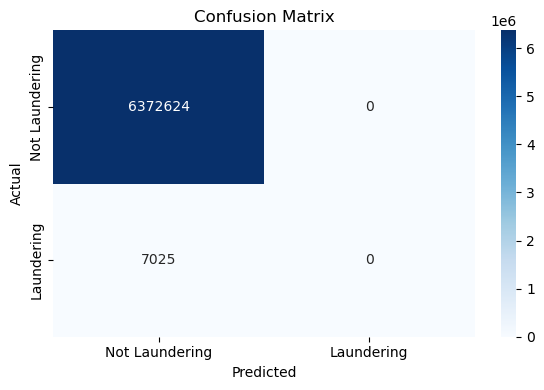

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_preds already created from earlier
# y_true: list of true labels from test set
# y_preds: list of predicted binary labels from model output (thresholded at 0.5)

cm = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Laundering", "Laundering"], yticklabels=["Not Laundering", "Laundering"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [8]:
# Save only the model's state_dict (weights)
torch.save(model.state_dict(), 'aml_model_weights.pth')
print("Model weights saved as aml_model_weights.pth")


Model weights saved as aml_model_weights.pth
